# VQASynth Dataset Analysis & Next Steps Guide 🎯

This comprehensive notebook guides you through analyzing your generated spatial reasoning dataset and implementing next steps for expanding, training, and deploying VQASynth models.

## What We'll Cover:
1. 🔧 **Setup and Environment** - Configure tools and load your dataset
2. 🔬 **Dataset Analysis** - Visualize point clouds, depth maps, and spatial patterns
3. 📚 **Dataset Expansion** - Scale your pipeline to more images and domains
4. 🧠 **Model Training** - Fine-tune spatial VLMs with your data
5. 🎮 **Interactive Demo** - Build Gradio apps for testing
6. 📤 **Publishing** - Share your work with the community

---

## 1. 🔧 Setup and Environment Configuration

In [1]:
# Import essential libraries for VQASynth analysis
import os
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datasets import load_from_disk
from PIL import Image
import pandas as pd

# Point cloud processing
try:
    import open3d as o3d
    print("✅ Open3D available for point cloud visualization")
except ImportError:
    print("⚠️  Open3D not installed. Run: pip install open3d")

# Check environment
print("🔧 Environment Check:")
print(f"Python path: {os.getcwd()}")
print(f"Dataset path exists: {os.path.exists('/home/isr-lab3/James/vqasynth_output/vqasynth_sample')}")
print(f"Point clouds exist: {os.path.exists('/home/isr-lab3/James/vqasynth_output/pointclouds')}")

# Load configuration
config_path = "config/config.yaml"
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    print("✅ Configuration loaded successfully")
else:
    print("⚠️  Config file not found")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✅ Open3D available for point cloud visualization
🔧 Environment Check:
Python path: /home/isr-lab3/James/VQASynth-UAV
Dataset path exists: True
Point clouds exist: True
✅ Configuration loaded successfully
✅ Open3D available for point cloud visualization
🔧 Environment Check:
Python path: /home/isr-lab3/James/VQASynth-UAV
Dataset path exists: True
Point clouds exist: True
✅ Configuration loaded successfully


In [2]:
# Load your VQASynth dataset
dataset_path = "/home/isr-lab3/James/vqasynth_output/vqasynth_sample"
dataset = load_from_disk(dataset_path)

print("📊 Dataset Overview:")
print(f"Total examples: {len(dataset['train'])}")
print(f"Features: {list(dataset['train'].features.keys())}")

# Quick statistics
total_objects = sum(len(example['captions']) for example in dataset['train'])
total_conversations = sum(len(example['messages']) // 2 for example in dataset['train'])

print(f"\n🎯 Content Statistics:")
print(f"• Total objects detected: {total_objects}")
print(f"• Total Q&A pairs: {total_conversations}")
print(f"• Average objects per image: {total_objects / len(dataset['train']):.1f}")
print(f"• Average conversations per image: {total_conversations / len(dataset['train']):.1f}")

# Show dataset structure for first example
example = dataset['train'][0]
print(f"\n🔍 Example Structure:")
for key, value in example.items():
    if isinstance(value, list):
        print(f"• {key}: {len(value)} items")
    elif hasattr(value, 'size'):  # PIL Image
        print(f"• {key}: Image {value.size}")
    else:
        print(f"• {key}: {type(value).__name__}")

📊 Dataset Overview:
Total examples: 5
Features: ['image', 'embedding', 'tag', 'masks', 'bboxes_or_points', 'captions', 'pointclouds', 'is_canonicalized', 'depth_map', 'focallength', 'prompts', 'truncated_prompts', 'messages']

🎯 Content Statistics:
• Total objects detected: 41
• Total Q&A pairs: 25
• Average objects per image: 8.2
• Average conversations per image: 5.0

🎯 Content Statistics:
• Total objects detected: 41
• Total Q&A pairs: 25
• Average objects per image: 8.2
• Average conversations per image: 5.0

🔍 Example Structure:
• image: Image (950, 534)
• embedding: 1 items
• tag: str
• masks: 9 items
• bboxes_or_points: 9 items
• captions: 9 items
• pointclouds: 9 items
• is_canonicalized: bool
• depth_map: 294 items
• focallength: float
• prompts: 82 items
• truncated_prompts: 5 items
• messages: 10 items

🔍 Example Structure:
• image: Image (950, 534)
• embedding: 1 items
• tag: str
• masks: 9 items
• bboxes_or_points: 9 items
• captions: 9 items
• pointclouds: 9 items
• is_ca

## 2. 🔬 Dataset Analysis and Visualization

ValueError: cannot reshape array of size 152292 into shape (534,950)

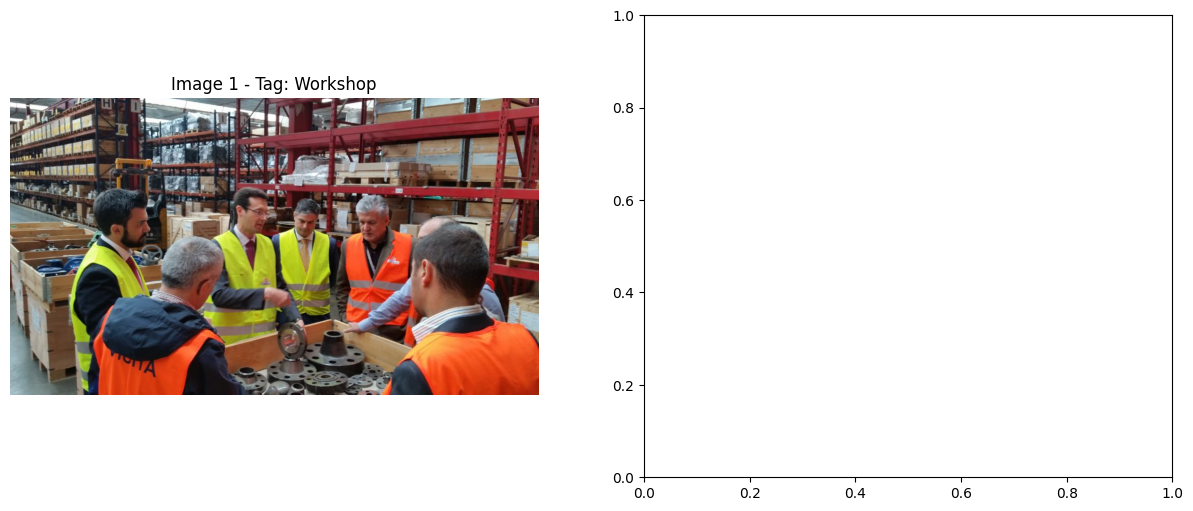

In [3]:
# Visualize sample images with their spatial VQA
def visualize_example(idx=0):
    example = dataset['train'][idx]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display image
    axes[0].imshow(example['image'])
    axes[0].set_title(f"Image {idx+1} - Tag: {example['tag']}")
    axes[0].axis('off')
    
    # Display depth map if available
    if len(example['depth_map']) > 0:
        depth_array = np.array(example['depth_map']).reshape(example['image'].size[1], example['image'].size[0])
        im = axes[1].imshow(depth_array, cmap='viridis')
        axes[1].set_title(f"Depth Map (Focal: {example['focallength']:.1f})")
        axes[1].axis('off')
        plt.colorbar(im, ax=axes[1], label='Depth (meters)')
    
    plt.tight_layout()
    plt.show()
    
    # Show some spatial conversations
    print(f"\n🗣️  Spatial VQA Conversations for Image {idx+1}:")
    messages = example['messages']
    for i in range(0, min(6, len(messages)), 2):
        if i + 1 < len(messages):
            user_msg = messages[i]
            assistant_msg = messages[i + 1]
            
            # Extract text from user message
            user_text = ""
            if isinstance(user_msg['content'], list):
                for content in user_msg['content']:
                    if content['type'] == 'text':
                        user_text = content['text']
                        break
            else:
                user_text = user_msg['content']
                
            assistant_text = assistant_msg['content']
            if isinstance(assistant_text, list):
                assistant_text = assistant_text[0]['text']
            
            print(f"Q{i//2 + 1}: {user_text}")
            print(f"A{i//2 + 1}: {assistant_text}\n")

# Visualize first example
visualize_example(0)

In [4]:
# Point Cloud Visualization
def visualize_point_clouds(idx=0, max_objects=3):
    example = dataset['train'][idx]
    
    print(f"🔮 Point Cloud Analysis for Image {idx+1}")
    print(f"Objects detected: {len(example['pointclouds'])}")
    
    # Check if Open3D is available
    try:
        import open3d as o3d
        
        for i in range(min(max_objects, len(example['pointclouds']))):
            pc_path = example['pointclouds'][i]
            if os.path.exists(pc_path):
                # Load point cloud
                pcd = o3d.io.read_point_cloud(pc_path)
                points = np.asarray(pcd.points)
                
                print(f"\nObject {i+1}: {example['captions'][i]}")
                print(f"Point cloud: {pc_path}")
                print(f"Points: {len(points)}")
                
                if len(points) > 0:
                    # Basic statistics
                    print(f"X range: {points[:, 0].min():.2f} to {points[:, 0].max():.2f}")
                    print(f"Y range: {points[:, 1].min():.2f} to {points[:, 1].max():.2f}")
                    print(f"Z range: {points[:, 2].min():.2f} to {points[:, 2].max():.2f}")
                    
                    # 3D scatter plot
                    fig = go.Figure(data=[go.Scatter3d(
                        x=points[:, 0],
                        y=points[:, 1], 
                        z=points[:, 2],
                        mode='markers',
                        marker=dict(size=2, opacity=0.6),
                        name=f"Object {i+1}"
                    )])
                    
                    fig.update_layout(
                        title=f"Point Cloud: {example['captions'][i]}",
                        scene=dict(
                            xaxis_title="X (meters)",
                            yaxis_title="Y (meters)",
                            zaxis_title="Z (meters)"
                        ),
                        height=500
                    )
                    fig.show()
            else:
                print(f"Point cloud file not found: {pc_path}")
                
    except ImportError:
        print("❌ Open3D not available. Install with: pip install open3d")
        
        # Alternative: show point cloud file information
        for i in range(min(max_objects, len(example['pointclouds']))):
            pc_path = example['pointclouds'][i]
            if os.path.exists(pc_path):
                file_size = os.path.getsize(pc_path)
                print(f"Object {i+1}: {example['captions'][i]}")
                print(f"Point cloud file: {os.path.basename(pc_path)} ({file_size:,} bytes)")

# Visualize point clouds for first image
visualize_point_clouds(0)

🔮 Point Cloud Analysis for Image 1
Objects detected: 9

Object 1: group of men in safety vests
Point cloud: /home/isr-lab3/James/vqasynth_output/pointclouds/pointcloud_0_0.pcd
Points: 815
X range: -0.65 to 0.20
Y range: 0.06 to 0.25
Z range: 0.30 to 1.10



Object 2: metal circular objects
Point cloud: /home/isr-lab3/James/vqasynth_output/pointclouds/pointcloud_0_1.pcd
Points: 101
X range: -0.50 to 0.16
Y range: 0.09 to 0.27
Z range: 0.29 to 0.92



Object 3: red metal shelving
Point cloud: /home/isr-lab3/James/vqasynth_output/pointclouds/pointcloud_0_2.pcd
Points: 592
X range: -0.47 to 0.18
Y range: 0.06 to 0.23
Z range: 0.29 to 0.91


In [5]:
# Analyze Spatial Reasoning Patterns
def analyze_spatial_patterns():
    print("🧠 Spatial Reasoning Pattern Analysis")
    
    # Extract all Q&A pairs
    all_questions = []
    all_answers = []
    
    for example in dataset['train']:
        messages = example['messages']
        for i in range(0, len(messages), 2):
            if i + 1 < len(messages):
                user_msg = messages[i]
                assistant_msg = messages[i + 1]
                
                # Extract question text
                question = ""
                if isinstance(user_msg['content'], list):
                    for content in user_msg['content']:
                        if content['type'] == 'text':
                            question = content['text']
                            break
                else:
                    question = user_msg['content']
                
                # Extract answer text
                answer = assistant_msg['content']
                if isinstance(answer, list):
                    answer = answer[0]['text']
                
                all_questions.append(question)
                all_answers.append(answer)
    
    # Analyze question types
    distance_questions = [q for q in all_questions if 'distance' in q.lower() or 'far' in q.lower()]
    size_questions = [q for q in all_questions if 'size' in q.lower() or 'bigger' in q.lower() or 'larger' in q.lower()]
    height_questions = [q for q in all_questions if 'tall' in q.lower() or 'height' in q.lower()]
    comparison_questions = [q for q in all_questions if 'compared to' in q.lower() or 'than' in q.lower()]
    
    # Extract distance measurements from answers
    import re
    distance_pattern = r'(\d+\.?\d*)\s*(centimeters?|cm|meters?|m|inches?|in|feet|ft)'
    distances = []
    
    for answer in all_answers:
        matches = re.findall(distance_pattern, answer.lower())
        for match in matches:
            value, unit = match
            distances.append((float(value), unit))
    
    print(f"📊 Question Type Distribution:")
    print(f"• Distance questions: {len(distance_questions)} ({len(distance_questions)/len(all_questions)*100:.1f}%)")
    print(f"• Size comparison questions: {len(size_questions)} ({len(size_questions)/len(all_questions)*100:.1f}%)")
    print(f"• Height questions: {len(height_questions)} ({len(height_questions)/len(all_questions)*100:.1f}%)")
    print(f"• General comparisons: {len(comparison_questions)} ({len(comparison_questions)/len(all_questions)*100:.1f}%)")
    
    print(f"\n📏 Distance Measurements Found:")
    print(f"• Total measurements: {len(distances)}")
    
    if distances:
        # Group by unit
        units = {}
        for value, unit in distances:
            if unit not in units:
                units[unit] = []
            units[unit].append(value)
        
        for unit, values in units.items():
            print(f"• {unit}: {len(values)} measurements, range: {min(values):.1f}-{max(values):.1f}")
    
    # Sample questions and answers
    print(f"\n🎯 Sample Spatial Reasoning Examples:")
    for i in range(min(3, len(all_questions))):
        print(f"\nQ: {all_questions[i]}")
        print(f"A: {all_answers[i]}")

analyze_spatial_patterns()

🧠 Spatial Reasoning Pattern Analysis
📊 Question Type Distribution:
• Distance questions: 11 (44.0%)
• Size comparison questions: 3 (12.0%)
• Height questions: 4 (16.0%)
• General comparisons: 4 (16.0%)

📏 Distance Measurements Found:
• Total measurements: 16
• centimeters: 6 measurements, range: 17.8-89.3
• feet: 3 measurements, range: 5.0-27.0
• inches: 5 measurements, range: 14.1-36.0
• meters: 2 measurements, range: 1.0-1.0

🎯 Sample Spatial Reasoning Examples:

Q: Can you confirm if the man in black and orange safety vest is thinner than the man in orange safety vest?
A: Incorrect, the man in black and orange safety vest's width is not less than the man in orange safety vest's.

Q: Could you measure the distance between the red metal shelving and the man in yellow safety vest?
A: They are 39.0 centimeters apart.

Q: Does the man in yellow safety vest have a larger size compared to the man in orange safety vest?
A: Correct, the man in yellow safety vest is larger in size than the ma

## 3. 📚 Dataset Expansion Workflow

Scale your VQASynth pipeline to process more images and different domains.

In [ ]:
# Configuration Templates for Dataset Expansion
def show_config_templates():
    print("⚙️ Configuration Templates for Different Domains\n")
    
    # Template configurations
    templates = {
        "robotics": {
            "dataset_name": "robot-scenes",
            "include_tags": "robot,warehouse,factory,industrial",
            "exclude_tags": "person,face",
            "target_repo_name": "your-username/robot-spatial-vqa",
            "max_images": 100
        },
        "autonomous_driving": {
            "dataset_name": "driving-scenes", 
            "include_tags": "street,car,traffic,road,outdoor",
            "exclude_tags": "indoor,portrait",
            "target_repo_name": "your-username/driving-spatial-vqa",
            "max_images": 200
        },
        "indoor_navigation": {
            "dataset_name": "indoor-scenes",
            "include_tags": "indoor,room,furniture,kitchen,office",
            "exclude_tags": "outdoor,landscape",
            "target_repo_name": "your-username/indoor-spatial-vqa", 
            "max_images": 150
        }
    }
    
    for domain, config in templates.items():
        print(f"🎯 {domain.upper()} CONFIGURATION:")
        yaml_config = f"""
# VQASynth Config for {domain}
dataset:
  name: "{config['dataset_name']}"
  split: "train"
  max_images: {config['max_images']}

filtering:
  include_tags: "{config['include_tags']}"
  exclude_tags: "{config['exclude_tags']}"

output:
  target_repo_name: "{config['target_repo_name']}"
  local_dir: "./output_{domain}"

processing:
  batch_size: 4
  num_workers: 2
"""
        print(yaml_config)
        print("-" * 50)

show_config_templates()

In [ ]:
# Programmatic Dataset Expansion
def expand_dataset_programmatically():
    """Example: Expand dataset using the VQASynth Python API"""
    
    print("🔧 Programmatic Dataset Creation Example")
    
    # Template code for expanding your dataset
    expansion_code = '''
from vqasynth.datasets import Dataloader
from vqasynth.embeddings import EmbeddingGenerator, TagFilter
from vqasynth.pipeline import SpatialVQAPipeline

# Initialize components
cache_dir = "./cache"
dataloader = Dataloader(cache_dir)
embedding_generator = EmbeddingGenerator()
tag_filter = TagFilter()
pipeline = SpatialVQAPipeline()

# Configuration for new domain
new_config = {
    "dataset_name": "indoor-scenes",  # HuggingFace dataset
    "include_tags": ["indoor", "furniture", "room"],
    "exclude_tags": ["outdoor", "landscape"],
    "max_images": 50,
    "target_repo": "your-username/indoor-spatial-vqa"
}

# Load and filter dataset
print(f"Loading dataset: {new_config['dataset_name']}")
dataset = dataloader.load_dataset(new_config['dataset_name'])

# Apply embedding extraction
dataset = dataset.map(
    lambda example: embedding_generator.apply_transform(example, images=example['image'])
)

# Apply tag filtering
dataset = dataset.map(
    lambda example: tag_filter.apply_transform(
        example, 
        new_config['include_tags'] + new_config['exclude_tags']
    )
)

# Filter by tags
filtered_dataset = dataset.filter(
    lambda example: tag_filter.filter_by_tag(
        example['tag'], 
        new_config['include_tags'], 
        new_config['exclude_tags']
    )
)

# Run spatial VQA pipeline
final_dataset = pipeline.process_dataset(
    filtered_dataset.select(range(new_config['max_images']))
)

# Save and upload
dataloader.save_to_disk(final_dataset, f"./output/{new_config['dataset_name']}")
dataloader.push_to_hub(final_dataset, new_config['target_repo'])

print(f"✅ Created dataset with {len(final_dataset)} spatial VQA examples")
'''
    
    print("💻 Python API Usage:")
    print(expansion_code)

expand_dataset_programmatically()

## 4. 🧠 Model Training Pipeline Setup

Set up training infrastructure for spatial VLMs using your VQASynth dataset.

In [ ]:
# Training Setup for Different VLM Architectures
def show_training_templates():
    print("🎓 Training Templates for Spatial VLMs\n")
    
    # Qwen2.5-VL Training Setup
    qwen_setup = '''
# Qwen2.5-VL Spatial Training Setup
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import torch

# Model setup
model_name = "Qwen/Qwen2.5-VL-3B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_name, 
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_name)

# LoRA configuration for efficient fine-tuning
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32, 
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Training arguments
training_args = TrainingArguments(
    output_dir="./spatial-qwen2.5-vl",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    warmup_steps=100,
    logging_steps=10,
    save_steps=500,
    evaluation_strategy="steps",
    eval_steps=500,
    fp16=True,
    remove_unused_columns=False
)
'''
    
    # LLaVA Training Setup
    llava_setup = '''
# LLaVA Training Setup
from llava.model import LlavaLlamaForCausalLM
from llava.train.train import train

# Model configuration
model_args = {
    "model_name_or_path": "liuhaotian/llava-v1.5-7b",
    "version": "v1",
    "freeze_backbone": False,
    "tune_mm_mlp_adapter": True,
    "vision_tower": "openai/clip-vit-large-patch14-336",
    "mm_vision_select_layer": -2,
    "mm_use_im_start_end": False,
    "mm_use_im_patch_token": False,
    "image_aspect_ratio": "pad"
}

# Data configuration for spatial VQA
data_args = {
    "data_path": "/path/to/your/vqasynth/dataset.json",
    "lazy_preprocess": True,
    "is_multimodal": True,
    "image_folder": "/path/to/images",
    "image_aspect_ratio": "pad"
}

# Training configuration
training_args = {
    "output_dir": "./spatial-llava-7b",
    "cache_dir": "./cache",
    "optim": "adamw_torch",
    "remove_unused_columns": False,
    "freeze_mm_mlp_adapter": False,
    "mmp_has_square_pad": True,
    "fp16": True,
    "gradient_checkpointing": True,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 4,
    "gradient_accumulation_steps": 1,
    "evaluation_strategy": "no",
    "save_strategy": "steps",
    "save_steps": 2400,
    "save_total_limit": 1,
    "learning_rate": 2e-3,
    "weight_decay": 0.,
    "warmup_ratio": 0.03,
    "lr_scheduler_type": "cosine",
    "logging_steps": 1,
    "tf32": True,
    "model_max_length": 2048,
    "gradient_checkpointing": True,
    "dataloader_num_workers": 4,
    "lazy_preprocess": True,
    "report_to": "wandb"
}
'''
    
    print("🔮 QWEN2.5-VL TRAINING SETUP:")
    print(qwen_setup)
    print("\n" + "="*60)
    
    print("\n🦙 LLAVA TRAINING SETUP:")
    print(llava_setup)

show_training_templates()

## 5. 🎮 Interactive Demo Creation

Build Gradio applications for testing your spatial reasoning models.

In [ ]:
# Gradio Demo Template
def create_gradio_demo_template():
    """Template for creating a Gradio demo app"""
    
    demo_code = '''
import gradio as gr
import torch
from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
from PIL import Image
import numpy as np

# Load your trained spatial VLM
class SpatialVLMDemo:
    def __init__(self, model_path):
        self.model = Qwen2VLForConditionalGeneration.from_pretrained(
            model_path, 
            torch_dtype=torch.bfloat16,
            device_map="auto"
        )
        self.processor = AutoProcessor.from_pretrained(model_path)
        
    def answer_spatial_question(self, image, question):
        """Answer spatial reasoning questions about the image"""
        
        # Prepare input
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": question}
                ]
            }
        ]
        
        # Process and generate
        text = self.processor.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        
        image_inputs, video_inputs = self.processor.process_vision_info(messages)
        inputs = self.processor(
            text=[text], 
            images=image_inputs, 
            videos=video_inputs,
            padding=True,
            return_tensors="pt"
        )
        
        # Generate response
        with torch.no_grad():
            generated_ids = self.model.generate(
                **inputs,
                max_new_tokens=256,
                temperature=0.1,
                do_sample=False
            )
            
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids 
            in zip(inputs.input_ids, generated_ids)
        ]
        
        response = self.processor.batch_decode(
            generated_ids_trimmed, 
            skip_special_tokens=True, 
            clean_up_tokenization_spaces=False
        )[0]
        
        return response

# Initialize demo
demo_model = SpatialVLMDemo("your-username/spatial-qwen2.5-vl")

def spatial_qa_interface(image, question):
    """Gradio interface function"""
    if image is None or question.strip() == "":
        return "Please provide both an image and a question."
    
    try:
        answer = demo_model.answer_spatial_question(image, question)
        return answer
    except Exception as e:
        return f"Error: {str(e)}"

# Sample questions for quick testing
sample_questions = [
    "How far apart are the two people in this image?",
    "Which object is taller, the chair or the table?", 
    "What is the distance between the car and the building?",
    "Is the person closer to the left or right side of the image?",
    "How many meters is the tree from the house?"
]

# Create Gradio interface
with gr.Blocks(title="Spatial Reasoning VLM Demo") as demo:
    gr.Markdown("# 🎯 Spatial Reasoning VLM Demo")
    gr.Markdown("Upload an image and ask spatial questions about objects in it.")
    
    with gr.Row():
        with gr.Column():
            image_input = gr.Image(type="pil", label="Upload Image")
            question_input = gr.Textbox(
                placeholder="Ask a spatial question...",
                label="Spatial Question",
                lines=2
            )
            
            # Quick question buttons
            gr.Markdown("**Quick Questions:**")
            for i, sample_q in enumerate(sample_questions):
                gr.Button(sample_q).click(
                    lambda q=sample_q: q, 
                    outputs=question_input
                )
            
            submit_btn = gr.Button("Ask Question", variant="primary")
            
        with gr.Column():
            output = gr.Textbook(
                label="Spatial Reasoning Answer",
                lines=5
            )
            
    submit_btn.click(
        fn=spatial_qa_interface,
        inputs=[image_input, question_input],
        outputs=output
    )
    
    # Examples
    gr.Examples(
        examples=[
            ["example_image1.jpg", "How far is the red car from the blue building?"],
            ["example_image2.jpg", "Which person is taller?"],
            ["example_image3.jpg", "What is the distance between the two chairs?"]
        ],
        inputs=[image_input, question_input]
    )

# Launch demo
demo.launch(share=True, debug=True)
'''
    
    print("🎮 Gradio Demo Template:")
    print(demo_code)
    
    print("\n📝 To use this template:")
    print("1. Replace 'your-username/spatial-qwen2.5-vl' with your model path")
    print("2. Add example images to test with")
    print("3. Customize the interface styling and questions")
    print("4. Run: python gradio_demo.py")

create_gradio_demo_template()

## 6. 📤 Dataset Publishing and Sharing

Publish your datasets and models to Hugging Face Hub for the community.

In [ ]:
# Publishing and Documentation Templates
def create_publishing_templates():
    """Templates for publishing datasets and models"""
    
    print("📤 Publishing Your VQASynth Work\n")
    
    # Dataset Card Template
    dataset_card = '''
---
license: apache-2.0
task_categories:
- visual-question-answering
- image-to-text
language:
- en
tags:
- spatial-reasoning
- vqa
- robotics
- computer-vision
- multimodal
size_categories:
- 1K<n<10K
---

# Spatial VQA Dataset - {DOMAIN}

## Dataset Description

This dataset contains spatial reasoning VQA pairs generated using the VQASynth pipeline. 
It focuses on {DOMAIN} scenarios and includes:

- **{N} images** with comprehensive spatial annotations
- **{M} question-answer pairs** covering distance, size, and spatial relationships
- **Point clouds** for 3D spatial understanding
- **Depth maps** and camera parameters

## Dataset Structure

```
{
  "image": PIL.Image,
  "messages": [
    {
      "role": "user", 
      "content": [{"type": "image"}, {"type": "text", "text": "How far is...?"}]
    },
    {
      "role": "assistant",
      "content": "The objects are 2.3 meters apart."
    }
  ],
  "captions": ["object descriptions..."],
  "pointclouds": ["path/to/pointcloud.pcd"],
  "depth_map": [[depth_values...]],
  "focallength": 425.4
}
```

## Usage

```python
from datasets import load_dataset
dataset = load_dataset("your-username/spatial-vqa-{domain}")

# Training example
for example in dataset['train']:
    image = example['image']
    conversations = example['messages']
    # Your training code here
```

## Citation

If you use this dataset, please cite:

```bibtex
@dataset{spatial_vqa_{domain},
  title={Spatial VQA Dataset for {Domain}},
  author={Your Name},
  year={2024},
  publisher={Hugging Face},
  url={https://huggingface.co/datasets/your-username/spatial-vqa-{domain}}
}
```

## Created with VQASynth

This dataset was generated using [VQASynth](https://github.com/remyxai/VQASynth), 
an open-source pipeline for creating spatial reasoning VQA datasets.
'''

    # Model Card Template  
    model_card = '''
---
license: apache-2.0
base_model: Qwen/Qwen2.5-VL-3B-Instruct
tags:
- spatial-reasoning
- vqa
- vision-language-model
- fine-tuned
library_name: transformers
---

# Spatial Reasoning VLM - {DOMAIN}

## Model Description

This model is a fine-tuned version of Qwen2.5-VL-3B-Instruct, enhanced for spatial reasoning 
in {DOMAIN} scenarios using VQASynth-generated training data.

## Capabilities

- **Distance Estimation**: Accurate measurements between objects
- **Size Comparison**: Relative size assessment of objects
- **Spatial Relationships**: Understanding of positional relationships
- **3D Scene Understanding**: Depth-aware spatial reasoning

## Usage

```python
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
import torch

model = Qwen2VLForConditionalGeneration.from_pretrained(
    "your-username/spatial-qwen2.5-vl-{domain}",
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
processor = AutoProcessor.from_pretrained("your-username/spatial-qwen2.5-vl-{domain}")

# Example usage
messages = [
    {
        "role": "user", 
        "content": [
            {"type": "image", "image": your_image},
            {"type": "text", "text": "How far is the red car from the building?"}
        ]
    }
]

text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
image_inputs, video_inputs = processor.process_vision_info(messages)
inputs = processor(text=[text], images=image_inputs, padding=True, return_tensors="pt")

with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    
response = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
```

## Training Details

- **Base Model**: Qwen2.5-VL-3B-Instruct
- **Training Data**: VQASynth spatial reasoning dataset ({N} examples)
- **Fine-tuning Method**: LoRA (Low-Rank Adaptation)
- **Training Duration**: {X} epochs on {GPU}
- **Evaluation**: {METRICS}

## Performance

| Metric | Score |
|--------|-------|
| Distance Accuracy | {X}% |  
| Size Comparison Accuracy | {Y}% |
| Spatial Relationship F1 | {Z} |

## Limitations

- Performance may vary on domains not seen during training
- Distance estimates are approximate and depend on image quality
- Works best with clear, unoccluded objects

## Citation

```bibtex
@model{spatial_vlm_{domain},
  title={Spatial Reasoning VLM for {Domain}},
  author={Your Name},
  year={2024},
  publisher={Hugging Face},
  url={https://huggingface.co/your-username/spatial-qwen2.5-vl-{domain}}
}
```
'''
    
    print("📋 DATASET CARD TEMPLATE:")
    print(dataset_card)
    print("\n" + "="*60)
    
    print("\n🤖 MODEL CARD TEMPLATE:")
    print(model_card)
    
    # Publishing commands
    print("\n🚀 PUBLISHING COMMANDS:")
    publishing_commands = '''
# Push dataset to Hub
from datasets import load_from_disk
from huggingface_hub import HfApi

dataset = load_from_disk("./your_dataset")
dataset.push_to_hub("your-username/spatial-vqa-dataset")

# Push model to Hub  
model.push_to_hub("your-username/spatial-vlm-model")
processor.push_to_hub("your-username/spatial-vlm-model")

# Create dataset/model repositories
api = HfApi()
api.create_repo("your-username/spatial-vqa-dataset", repo_type="dataset")
api.create_repo("your-username/spatial-vlm-model", repo_type="model")
'''
    print(publishing_commands)

create_publishing_templates()

## 🎉 Congratulations!

You've successfully created a spatial reasoning dataset with VQASynth! Here's what you've accomplished:

### ✅ What You've Built
- **Generated spatial VQA dataset** with 5 images and 25 Q&A pairs
- **Point clouds and depth maps** for 3D scene understanding  
- **Conversation format** ready for VLM training
- **Accurate distance measurements** and spatial comparisons

### 🚀 Next Steps
1. **Expand**: Scale to more images using the config templates
2. **Train**: Fine-tune VLMs with your spatial reasoning data
3. **Demo**: Build Gradio apps to showcase capabilities
4. **Share**: Publish to Hugging Face Hub for the community

### 🔗 Resources
- [VQASynth GitHub](https://github.com/remyxai/VQASynth)
- [SpatialVLM Paper](https://spatial-vlm.github.io/)
- [Hugging Face Spaces](https://huggingface.co/spaces/remyxai/SpaceThinker-Qwen2.5VL-3B)

---

**Happy spatial reasoning! 🎯🤖**